In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from ESN import *
from SpaRCe import *

%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Processing ESN activities

The following cell is to compute the ESN activity across the dataset. If one has already the response of a reservoir to the original dataset, then Reservoir_processed=True and it is possible to import the data. In the latter case, the following instructions are not needed.

There are two possible examples to run (to compute the ESN activities): the first corresponds to the MNIST dataset, coloumn by column, where each image is read as a 28-d sequence of 28 temporal steps (D1=False). The second uses the MNIST dataset again, but each image is read as a 1-d sequence of 784 temporal steps (D1=true). If you have a dataset to try, a training set X_tr (and the corresponding one-hot encoding Y_tr), and a test set X_te (and the corresponding one-hot encoding Y_te) should be always provided, while the validation set X_val and Y_val can be set equal to False. The shape of the dataset should be $[N_{samples},N_{in},T]$ for a $N_{in}$ dimensional input, and only $[N_{samples},T]$ for a 1-d input. T corresponds to the temporal lenght of the sequences to be classified. Set D1=True for 1-d sequences, or D1=False for multi-d sequences.

Furthermore, it is possible to choose between a single ESN (ESN_single=True) and two ESN hierarchically connected (ESN_single=False). The hyperparameters to set are:

<ul>
    <li> alpha1, alpha2: leakage term of the reservoir 1 and 2 </li>
    <li> pho1, pho2: $\rho$ of the reservoir 1 and 2 </li>
    <li> diluition1, diluition2: probability of a zero in the connectivity matrix of ESN 1 and 2 </li> 
    <li> N1, N2: number of nodes of ESN 1 and 2 </li>
    <li> W1_in, W2_in: input connectivity matrix of ESN 1 and 2 </li>
    <li> gamma12: multiplicative factor of the connectivity matrix between the two ESN
        <li> T_conc: the multiples of T_conc define the values for the readout. In the example case of 1-d input T_conc can be 1, while in the case of 28-d input we suggest a T_conc=28. </li>
    
</ul>

In the example below, decent hyperparameters values are already provided. For a 1-d dimensional input we use a binary input mask with values 1,-1. For a 28-d input we use a gaussian input connectivity matrix.
In the case you specify your input connectivity matrix, W_in should be a 1-d array for a 1-d input, and a 2-d array (shape $[N_{in},N]$) for a multi-d input.




Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Computing States for the training set
Computing States for the test set


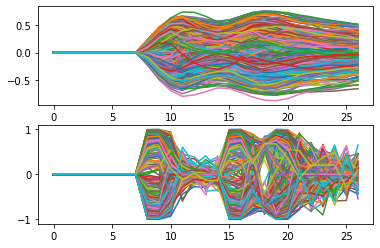

In [2]:
Reservoir_processed=False    

if Reservoir_processed==False:
    
    ## Import the dataset...this is an example of sequences with multi-D input
    
    D1=True
    if D1==False:
        
        from tensorflow.examples.tutorials.mnist import input_data
        mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
        X_tr=np.reshape(mnist.train.images,[-1,28,28])
        Y_tr=mnist.train.labels
        X_te=np.reshape(mnist.test.images,[-1,28,28])
        Y_te=mnist.test.labels
        X_val=False
        Y_val=False
    
    ## Example of sequences with 1-D input 
    
    if D1==True:
        
        from tensorflow.examples.tutorials.mnist import input_data
        mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
        X_tr=mnist.train.images
        Y_tr=mnist.train.labels
        X_te=mnist.test.images
        Y_te=mnist.test.labels
        X_val=False
        Y_val=False

    ESN_Single=False
    
    ## Single ESN
    if ESN_Single==True:
        
        ## Set ESN hyperparameters
        
        N=1000                                        
        alpha=0.17
        pho=0.97
        N_av=10
        diluition=1-N_av/N
        gamma=1       
        
        
        if D1==False:
            T=np.shape(X_tr)[2]
            W_in=gamma*np.random.randn(np.shape(X_tr)[1],N)
            
            T_conc=np.int32(np.linspace(0,T-1,T))
            
        else:
            T=np.shape(X_tr)[1]
            W_in=np.ones(N)
            W_in[np.random.uniform(0,1,N)<0.5]=-1
            
            T_conc=np.int32(np.linspace(0,T-1,28))  
        
        ## End of the ESN hyperparameters setting
        
        esn=ESN1(alpha, pho, diluition, N, W_in, T, T_conc)

        train_divide=100
        test_divide=50
        val_divide=50

        S_tr,S_te,S_val=esn.Computation(X_tr,X_te,X_val,train_divide,test_divide,val_divide)
    
    ##Double ESN
    if ESN_Single==False:
        
        ## Set ESN hyperparameters
        
        N1=500
        N2=300                                     

        alpha1=0.02
        alpha2=1
        
        pho1=0.97
        pho2=1
        
        N1_av=5
        diluition1=1-N1_av/N1
        N2_av=3
        diluition2=1-N2_av/N2
        gamma1=1
        gamma12=0.15
        
        if D1==False:
            
            T=np.shape(X_tr)[2]
            W2_in=gamma*np.random.randn(np.shape(X_tr)[1],N2)
            
            T_conc=np.int32(np.linspace(0,T-1,T))
        
        else:
            
            T=np.shape(X_tr)[1]
            W2_in=np.ones(N2)
            W2_in[np.random.uniform(0,1,N2)<0.5]=-1
            
            T_conc=np.int32(np.linspace(0,T-1,28)) 
        
        W1_in=0
        
        ## End of the ESN hyperparameters setting
        
        esn=ESN2(alpha1, pho1, diluition1, N1, W1_in,
                alpha2, pho2, diluition2, N2, W2_in, gamma12, T, T_conc)

        
        train_divide=100
        test_divide=50
        val_divide=50

        S_tr,S_te,S_val=esn.Computation(X_tr,X_te,X_val,train_divide,test_divide,val_divide)
        

    if X_val==False:
        S_val=False
    
    #else:
    #    np.save('Act_val',S_val)
        
    #np.save('Act_train',S_tr)
    #np.save('Act_test',S_te)
        
else: 
    
    ## Import your preprocessed data 
    
    S_tr=np.importdata('Act_train')
    S_te=np.importdata('Act_test',S_te)
    S_val=False
    
    if S_val is not(False):
        S_val.savetxt('Act_val',S_val)
        
    
    
    
    

## SpaRCe and training

You should have a dataset composed by S_tr, S_val, S_te, the activities of the reservoir for the training, validation and test set, and the corresponding one-hot encoded labels Y_tr, Y_val, Y_te. S_tr should have the size $[N_{samples},N,T]$ where N are the nodes in the reservoir and T is the time lenght of the sequences. 

Model=1 will train SpaRCe, from different possible starting sparsity levels.
Model=2 will train a standard perceptron.

One needs to specify the different starting sparsity level Pns for SpaRCe.

In [3]:
batch_size=20
N_minibatch=200000
N_check=10

alpha_size=[0.002]
Pns=[0,20,40,60,80]

train_divide=13
test_divide=13
val_divide=13

Model=Models(alpha_size,Pns,batch_size,N_minibatch,N_check,S_tr,S_val,S_te,Y_tr,Y_val,Y_te)

MODEL=1
Results_tr, Results_te, Results_val=Model.Training(MODEL,train_divide,test_divide,val_divide)



Instructions for updating:
Use tf.cast instead.
Iteration:  0 SpaRCe  0 Probability:  0.0874262280189074 Error:  0.6895300617983708 Coding  0.9706540441126936
Iteration:  0 SpaRCe  0 Probability:  0.08336060848988437 Error:  0.6893302065700918 Coding  0.9703619084155969
Iteration:  0 SpaRCe  1 Probability:  0.10263079003645825 Error:  0.6938068360502904 Coding  0.8024879242512026
Iteration:  0 SpaRCe  1 Probability:  0.10960174248237294 Error:  0.693604863750351 Coding  0.7976730404041147
Iteration:  0 SpaRCe  2 Probability:  0.18405518798392553 Error:  0.6943124213131574 Coding  0.6175085220765573
Iteration:  0 SpaRCe  2 Probability:  0.19218039179692317 Error:  0.6941015863501941 Coding  0.611018144345818
Iteration:  0 SpaRCe  3 Probability:  0.08232469799426888 Error:  0.6939564564865369 Coding  0.4237117180236867
Iteration:  0 SpaRCe  3 Probability:  0.07992362012698516 Error:  0.6938189287669175 Coding  0.41714723208894183
Iteration:  0 SpaRCe  4 Probability:  0.08032409789470527 

KeyboardInterrupt: 